Note that this notebook requires both the `onnx` and `onnxruntime` optional dependencies, in addition to `opencv-python` and `matplotlib` for visualization.

If running locally using jupyter, first install segment_anything in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository.

You can run this notebook in [Google Colab](https://colab.research.google.com/drive/1wmjHHcrZ_s8iFuVFh9iHo6GbUS_xH5xq?usp=sharing).

In [2]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything.utils.transforms import ResizeLongestSide
from torch.nn import functional as F

import onnxruntime

In [3]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [3]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

Ein Unterverzeichnis oder eine Datei mit dem Namen "images" existiert bereits.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [4]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

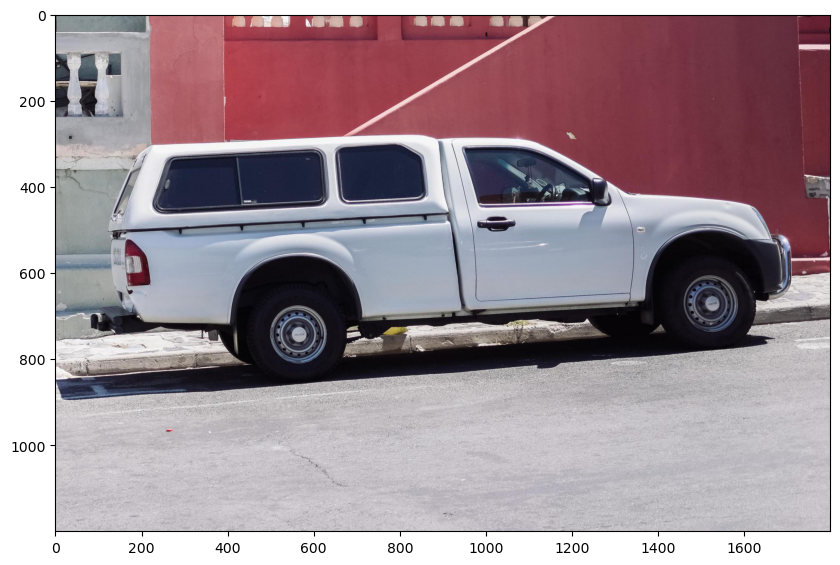

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [6]:
!wget https://huggingface.co/visheratin/segment-anything-vit-b/resolve/main/encoder-quant.onnx
!wget https://huggingface.co/visheratin/segment-anything-vit-b/resolve/main/decoder-quant.onnx

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [21]:
# encoder_path = "./encoder-quant.onnx"
# encoder_path = "A:/Pytorch/segment-anything/notebooks/encoder-quant.onnx" --> seems to be not allright!
encoder_path = "A:/Inferenz/sam_vit_b.encoder.onnx"
# decoder_path = "./decoder-quant.onnx"
# decoder_path = "A:/Pytorch/segment-anything/notebooks/decoder-quant.onnx"
decoder_path = "A:/Inferenz/sam_vit_b.decoder.onnx" 

encoder_session = onnxruntime.InferenceSession(encoder_path)
decoder_session = onnxruntime.InferenceSession(decoder_path)

In [28]:
from numpy import transpose


image_size = 1024
transform = ResizeLongestSide(image_size)

input_image = transform.apply_image(image)
input_image_torch = torch.as_tensor(input_image, device="cpu")
input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)
x = (input_image_torch - pixel_mean) / pixel_std
h, w = x.shape[-2:]
padh = image_size - h
padw = image_size - w
x = F.pad(x, (0, padw, 0, padh))
x = x.numpy()
img_in = x[0, ...]
img_in = transpose(img_in, (1,2,0))
print(f"shape = {img_in.shape}")

shape = (3, 1024, 1024)


In [29]:

encoder_inputs = {
    # "x": x, # original example
    "input_image": img_in, # DS: custom export
}

output = encoder_session.run(None, encoder_inputs)
image_embedding = output[0]

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input_image for the following indices
 index: 2 Got: 1024 Expected: 3
 Please fix either the inputs or the model.

To use the ONNX model, the image must first be pre-processed using the SAM image encoder. This is a heavier weight process best performed on GPU. SamPredictor can be used as normal, then `.get_image_embedding()` will retreive the intermediate features.

The ONNX model has a different input signature than `SamPredictor.predict`. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are `np.float32`.
* `image_embeddings`: The image embedding from `predictor.get_image_embedding()`. Has a batch index of length 1.
* `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. *Coordinates must already be transformed to long-side 1024.* Has a batch index of length 1.
* `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.*
* `mask_input`: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
* `has_mask_input`: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
* `orig_im_size`: The size of the input image in (H,W) format, before any transformation. 

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at `sam.mask_threshold` (equal to 0.0).

### Example point input

In [12]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

Add a batch index, concatenate a padding point, and transform.

In [13]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


Create an empty mask input and an indicator for no mask.

In [14]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

Package the inputs to run in the onnx model

In [15]:
decoder_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

Predict a mask and threshold it.

In [16]:
masks, _, low_res_logits = decoder_session.run(None, decoder_inputs)
masks = masks > 0.0

In [17]:
masks.shape

(1, 4, 1200, 1800)

ValueError: cannot reshape array of size 8640000 into shape (1200,1800,1)

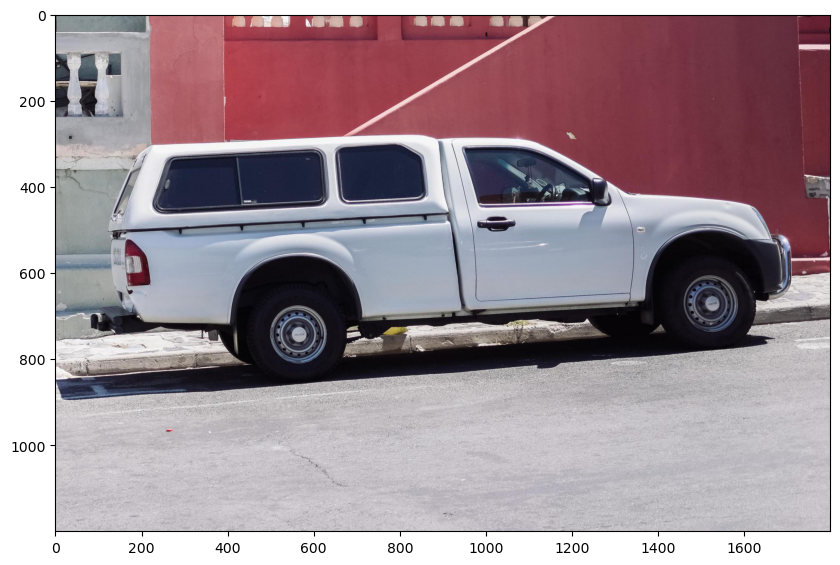

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example mask input

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

Transform the points as in the previous example.

In [ ]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

The `has_mask_input` indicator is now 1.

In [ ]:
onnx_has_mask_input = np.ones(1, dtype=np.float32)

Package inputs, then predict and threshold the mask.

In [ ]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = decoder_session.run(None, ort_inputs)
masks = masks > 0.0

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example box and point input

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.

In [ ]:
onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

Package inputs, then predict and threshold the mask.

In [ ]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = decoder_session.run(None, ort_inputs)
masks = masks > 0.0

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()